In [1]:
from Bio import SeqIO
from Bio.SeqUtils import GC
import gzip
import numpy as np
import pandas as pd
import pickle
import random
import re
import seaborn as sns

In [2]:
# Matrix
data = np.load("./matrix2d.ReMap+UniBind.sparse.npz")
for i in data.files:
    matrix2d = data[i]
matrix2d

array([[nan,  0., nan, ..., nan, nan, nan],
       [ 0.,  0., nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [3]:
# Regions
with gzip.open("./regions_idx.pickle.gz", "rb") as f:
    regions_dict = pickle.load(f)
regions_df = pd.Series(regions_dict).sort_values()
regions_df

chr1  10095     10295             0
      16145     16345             1
      56175     56375             2
      90115     90315             3
      96495     96695             4
                             ...   
chrY  56878155  56878355    1817913
      56878675  56878875    1817914
      56880415  56880615    1817915
      56881535  56881735    1817916
      56881775  56881975    1817917
Length: 1817918, dtype: int64

In [4]:
# TFs
with gzip.open("./tfs_idx.pickle.gz", "rb") as f:
    tfs_dict = pickle.load(f)
tfs_df = pd.Series(tfs_dict).sort_values()
tfs_df

AHR         0
AR          1
ARID3A      2
ARNT        3
ATF1        4
         ... 
ZNF143    158
ZNF24     159
ZNF263    160
ZNF384    161
ZNF740    162
Length: 163, dtype: int64

In [5]:
# CTCF regions
ctcf_regions = pd.Series(
    matrix2d[:, tfs_df["CTCF"]], index=regions_df.values
).dropna()
ctcf_regions

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1817912    0.0
1817913    0.0
1817914    0.0
1817915    0.0
1817916    0.0
Length: 1656242, dtype: float64

In [6]:
# Positive regions
positive_regions = ctcf_regions[ctcf_regions == 1].index
positive_regions

Int64Index([      7,      16,      22,      49,     107,     112,     124,
                144,     175,     179,
            ...
            1817571, 1817618, 1817621, 1817700, 1817706, 1817711, 1817721,
            1817723, 1817732, 1817832],
           dtype='int64', length=78984)

In [7]:
# Negative regions
negative_regions = ctcf_regions[ctcf_regions == 0].index
negative_regions

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  8,       9,      10,
            ...
            1817907, 1817908, 1817909, 1817910, 1817911, 1817912, 1817913,
            1817914, 1817915, 1817916],
           dtype='int64', length=1577258)

In [9]:
# FASTA sequences
positive_sequences = {}
for i in range(101):
    positive_sequences.setdefault(i, [])
negative_sequences = {}
for i in range(101):
    negative_sequences.setdefault(i, [])
sequences = {}
with gzip.open("./sequences.200bp.fa.gz", "rt") as f:
    for seq_record in SeqIO.parse(f, "fasta"):
        region, coordinates = seq_record.id.split("::")
        region = int(region)
        sequence = str(seq_record.seq)
        if re.search("[^acgtACGT]", sequence):
            pass
        elif region in positive_regions:
            positive_sequences[round(GC(sequence))].append(region)
            sequences.setdefault(region, sequence)
        elif region in negative_regions:
            negative_sequences[round(GC(sequence))].append(region)
            sequences.setdefault(region, sequence)
len(sequences)

1656212

In [12]:
# Downsampling
sampled = {}
random_seed = 123
for i in range(101):
    random.Random(random_seed).shuffle(positive_sequences[i])
    random.Random(random_seed).shuffle(negative_sequences[i])
    min_length = min(
        [len(positive_sequences[i]), len(negative_sequences[i])]
    )
    for j in range(min_length):
        sampled.setdefault("positives", set())
        sampled["positives"].add(positive_sequences[i][j])
        sampled.setdefault("negatives", set())
        sampled["negatives"].add(negative_sequences[i][j])
print(len(sampled["positives"]), len(sampled["negatives"]))

78983 78983


In [19]:
# Save sequences
with gzip.open("./pos_seqs.fa.gz", "wb") as f:
    for positive in sorted(sampled["positives"]):
        string = ">%s\n%s\n" % (positive, sequences[positive])
        f.write(string.encode("utf-8"))
with gzip.open("./neg_seqs.fa.gz", "wb") as f:
    for negative in sorted(sampled["negatives"]):
        string = ">%s\n%s\n" % (negative, sequences[negative])
        f.write(string.encode("utf-8"))

In [20]:
# Sanity check
gc_positives = []
gc_negatives = []
with gzip.open("./pos_seqs.fa.gz", "rt") as f:
    for seq_record in SeqIO.parse(f, "fasta"):
        gc_positives.append(GC(str(seq_record.seq)))
gc_positives = np.array(gc_positives)
with gzip.open("./neg_seqs.fa.gz", "rt") as f:
    for seq_record in SeqIO.parse(f, "fasta"):
        gc_negatives.append(GC(str(seq_record.seq)))
gc_negatives = np.array(gc_negatives)
print(len(gc_positives), len(gc_negatives))

78983 78983


In [21]:
# DataFrame
data = []
for i in gc_positives:
    data.append(["positives", i])
for i in gc_negatives:
    data.append(["negatives", i])
df = pd.DataFrame(data, columns=["Sequence", "%GC"])
df

,Sequence,%GC
0,positives,57.0
1,positives,55.0
2,positives,53.0
3,positives,64.0
4,positives,47.5
...,...,...
157961,negatives,40.0
157962,negatives,48.0
157963,negatives,46.5
157964,negatives,38.5


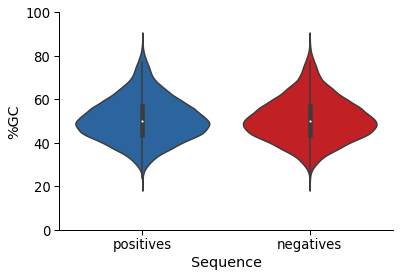

In [22]:
# Plot %GC distributions
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_palette(sns.color_palette(["#1965B0", "#DC050C"]))
g = sns.violinplot(x="Sequence", y="%GC", data=df)
g.set(ylim=(0, 100))
sns.despine()